MODEL 3

In [139]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

Data: 'nst-est2019-alldata.csv', 'us-states.csv'  

In [140]:
df_demo = pd.read_csv('nst-est2019-alldata.csv')
df_raw = pd.read_csv('us-states.csv')

Preprocessing

In [141]:
df = pd.merge(df_raw, df_demo[['NAME','POPESTIMATE2019','DEATHS2019']], how = "left", left_on = "state", right_on = "NAME")
df['log_cases'] = np.log(df['cases']+1)
df['log_deaths'] = np.log(df['deaths']+1)
df['log_pop19'] = np.log(df['POPESTIMATE2019']+1)
df['log_death19'] = np.log(df['DEATHS2019']+1)

In [142]:
np.isnan(np.nan)

True

In [143]:
group = df.groupby("state")[["log_cases","log_deaths","log_pop19","log_death19"]].agg(list).reset_index()

In [144]:
window=10
x = []
y = []
demo = []
for index,row in group.iterrows():
    state = row['state']
    cases = row['log_cases']
    deaths = row['log_deaths']
    pop19 = row['log_pop19'][0]
    death19 = row['log_death19'][0]
    if np.isnan(pop19) or np.isnan(death19):
        continue
        
    for i in range(len(cases)-window-1):
        cc = np.array(cases[i:i+window]).reshape(-1,1)
        dd = np.array(deaths[i:i+window]).reshape(-1,1)
        new_x = np.concatenate([cc,dd],axis=1) 
        x.append(new_x) 
        demo.append(np.array([pop19, death19]))
        y.append(np.array([cases[i+window], deaths[i+window]]))

Splitting the data

In [145]:
x = np.array(x) 
y = np.array(y)
demo = np.array(demo)

index = np.arange(x.shape[0])
np.random.shuffle(index)
cutoff = int(0.7 * x.shape[0])
x_train, x_test = x[index[:cutoff]], x[index[cutoff:]]
y_train, y_test = y[index[:cutoff]], y[index[cutoff:]]
demo_train, demo_test = demo[index[:cutoff]], demo[index[cutoff:]]

Model 1: model_final_layer includes demographic data at the final layer only.

In [146]:
hidden_dim = 10
optimizer = Adam(learning_rate=0.001)

input_ = Input(shape=(x.shape[1:]))
demo_input = Input(shape=(demo.shape[1:]))

rnn = LSTM(hidden_dim, return_sequences=False)(input_)

temp = Dense(hidden_dim, activation = 'relu')(rnn)
full_data = Concatenate()([temp, demo_input])
output = Dense(y.shape[-1])(full_data) 
model_final_layer = Model(inputs=[input_, demo_input], outputs=output)
# print(model_final_layer.summary())

Model 2: model_mid_layer includes demographic data after the RNN and before the additional Dense layer

In [147]:
input_ = Input(shape=(x.shape[1:]))
demo_input = Input(shape=(demo.shape[1:]))

rnn = LSTM(hidden_dim, return_sequences=False)(input_)

full_data = Concatenate()([rnn, demo_input])
temp = Dense(hidden_dim, activation = 'relu')(full_data)

output = Dense(y.shape[-1])(temp) 
model_mid_layer = Model(inputs=[input_, demo_input], outputs=output)
# print(model_mid_layer.summary())

Model 3: model_no_demo does not include the demographic data.  For consistency of syntax the demographic input is still included, but not used.

In [148]:
input_ = Input(shape=(x.shape[1:]))
demo_input = Input(shape=(demo.shape[1:]))

rnn = LSTM(hidden_dim, return_sequences=False)(input_)

temp = Dense(hidden_dim, activation = 'relu')(rnn)

output = Dense(y.shape[-1])(temp) 
model_no_demo = Model(inputs=[input_, demo_input], outputs=output)
print(model_no_demo.summary())

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
lstm_20 (LSTM)                  (None, 10)           520         input_41[0][0]                   
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 10)           110         lstm_20[0][0]                    
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 2)]          0                                            
___________________________________________________________________________________________

In [149]:
# model_final_layer.compile(loss='mse', optimizer=optimizer)
# model_mid_layer.compile(loss='mse', optimizer=optimizer)
model_no_demo.compile(loss='mse', optimizer=optimizer)

In [150]:
# model_final_layer.fit([x_train, demo_train], y_train, batch_size = 40, epochs = 400, validation_data = ([x_test, demo_test], y_test))
# model_mid_layer.fit([x_train, demo_train], y_train, batch_size = 40, epochs = 400, validation_data = ([x_test, demo_test], y_test))
model_no_demo.fit([x_train, demo_train], y_train, batch_size = 40, epochs = 400, validation_data = ([x_test, demo_test], y_test))

Train on 953 samples, validate on 409 samples
Epoch 1/400
953/953 [==============================] - 2s 2ms/sample - loss: 20.7144 - val_loss: 18.0302
Epoch 2/400
953/953 [==============================] - 0s 238us/sample - loss: 17.6289 - val_loss: 15.8479
Epoch 3/400
953/953 [==============================] - 0s 240us/sample - loss: 15.5201 - val_loss: 13.7653
Epoch 4/400
953/953 [==============================] - 0s 238us/sample - loss: 13.1133 - val_loss: 11.1423
Epoch 5/400
953/953 [==============================] - 0s 240us/sample - loss: 10.0221 - val_loss: 7.9355
Epoch 6/400
953/953 [==============================] - 0s 243us/sample - loss: 6.8258 - val_loss: 5.1117
Epoch 7/400
953/953 [==============================] - 0s 230us/sample - loss: 4.2701 - val_loss: 3.1294
Epoch 8/400
953/953 [==============================] - 0s 231us/sample - loss: 2.5625 - val_loss: 1.8783
Epoch 9/400
953/953 [==============================] - 0s 228us/sample - loss: 1.5742 - val_loss: 1.1908
Ep

Epoch 78/400
953/953 [==============================] - 0s 254us/sample - loss: 0.0331 - val_loss: 0.0324
Epoch 79/400
953/953 [==============================] - 0s 253us/sample - loss: 0.0328 - val_loss: 0.0327
Epoch 80/400
953/953 [==============================] - 0s 240us/sample - loss: 0.0326 - val_loss: 0.0322
Epoch 81/400
953/953 [==============================] - 0s 245us/sample - loss: 0.0325 - val_loss: 0.0321
Epoch 82/400
953/953 [==============================] - 0s 254us/sample - loss: 0.0326 - val_loss: 0.0317
Epoch 83/400
953/953 [==============================] - 0s 230us/sample - loss: 0.0322 - val_loss: 0.0320
Epoch 84/400
953/953 [==============================] - 0s 234us/sample - loss: 0.0321 - val_loss: 0.0319
Epoch 85/400
953/953 [==============================] - 0s 248us/sample - loss: 0.0318 - val_loss: 0.0330
Epoch 86/400
953/953 [==============================] - 0s 299us/sample - loss: 0.0319 - val_loss: 0.0329
Epoch 87/400
953/953 [========================

Epoch 155/400
953/953 [==============================] - 0s 275us/sample - loss: 0.0261 - val_loss: 0.0265
Epoch 156/400
953/953 [==============================] - 0s 336us/sample - loss: 0.0260 - val_loss: 0.0263
Epoch 157/400
953/953 [==============================] - 0s 321us/sample - loss: 0.0264 - val_loss: 0.0282
Epoch 158/400
953/953 [==============================] - 0s 283us/sample - loss: 0.0268 - val_loss: 0.0263
Epoch 159/400
953/953 [==============================] - 0s 232us/sample - loss: 0.0267 - val_loss: 0.0270
Epoch 160/400
953/953 [==============================] - 0s 236us/sample - loss: 0.0272 - val_loss: 0.0264
Epoch 161/400
953/953 [==============================] - 0s 237us/sample - loss: 0.0266 - val_loss: 0.0266
Epoch 162/400
953/953 [==============================] - 0s 229us/sample - loss: 0.0266 - val_loss: 0.0259
Epoch 163/400
953/953 [==============================] - 0s 232us/sample - loss: 0.0262 - val_loss: 0.0261
Epoch 164/400
953/953 [==============

953/953 [==============================] - 0s 221us/sample - loss: 0.0252 - val_loss: 0.0257
Epoch 232/400
953/953 [==============================] - 0s 226us/sample - loss: 0.0251 - val_loss: 0.0254
Epoch 233/400
953/953 [==============================] - 0s 217us/sample - loss: 0.0248 - val_loss: 0.0259
Epoch 234/400
953/953 [==============================] - 0s 206us/sample - loss: 0.0248 - val_loss: 0.0254
Epoch 235/400
953/953 [==============================] - 0s 212us/sample - loss: 0.0249 - val_loss: 0.0261
Epoch 236/400
953/953 [==============================] - 0s 225us/sample - loss: 0.0253 - val_loss: 0.0251
Epoch 237/400
953/953 [==============================] - 0s 225us/sample - loss: 0.0245 - val_loss: 0.0257
Epoch 238/400
953/953 [==============================] - 0s 237us/sample - loss: 0.0246 - val_loss: 0.0250
Epoch 239/400
953/953 [==============================] - 0s 226us/sample - loss: 0.0248 - val_loss: 0.0251
Epoch 240/400
953/953 [============================

953/953 [==============================] - 0s 239us/sample - loss: 0.0247 - val_loss: 0.0253
Epoch 308/400
953/953 [==============================] - 0s 231us/sample - loss: 0.0241 - val_loss: 0.0248
Epoch 309/400
953/953 [==============================] - 0s 231us/sample - loss: 0.0241 - val_loss: 0.0242
Epoch 310/400
953/953 [==============================] - 0s 231us/sample - loss: 0.0237 - val_loss: 0.0249
Epoch 311/400
953/953 [==============================] - 0s 233us/sample - loss: 0.0243 - val_loss: 0.0243
Epoch 312/400
953/953 [==============================] - 0s 238us/sample - loss: 0.0237 - val_loss: 0.0243
Epoch 313/400
953/953 [==============================] - 0s 237us/sample - loss: 0.0239 - val_loss: 0.0247
Epoch 314/400
953/953 [==============================] - 0s 233us/sample - loss: 0.0237 - val_loss: 0.0254
Epoch 315/400
953/953 [==============================] - 0s 233us/sample - loss: 0.0244 - val_loss: 0.0248
Epoch 316/400
953/953 [============================

953/953 [==============================] - 0s 269us/sample - loss: 0.0240 - val_loss: 0.0256
Epoch 384/400
953/953 [==============================] - 0s 303us/sample - loss: 0.0239 - val_loss: 0.0242
Epoch 385/400
953/953 [==============================] - 0s 275us/sample - loss: 0.0236 - val_loss: 0.0240
Epoch 386/400
953/953 [==============================] - 0s 249us/sample - loss: 0.0239 - val_loss: 0.0247
Epoch 387/400
953/953 [==============================] - 0s 227us/sample - loss: 0.0242 - val_loss: 0.0261
Epoch 388/400
953/953 [==============================] - 0s 227us/sample - loss: 0.0242 - val_loss: 0.0249
Epoch 389/400
953/953 [==============================] - 0s 243us/sample - loss: 0.0242 - val_loss: 0.0266
Epoch 390/400
953/953 [==============================] - 0s 315us/sample - loss: 0.0238 - val_loss: 0.0249
Epoch 391/400
953/953 [==============================] - 0s 225us/sample - loss: 0.0242 - val_loss: 0.0242
Epoch 392/400
953/953 [============================

In [162]:
# y_pred = model_final_layer.predict([x_test, demo_test])
# y_pred = model_mid_layer.predict([x_test, demo_test])
y_pred = model_no_demo.predict([x_test, demo_test])

array([[ 7.53058195e-01, -1.00799203e-02],
       [ 7.11128283e+00,  2.57143140e+00],
       [ 7.97554159e+00,  4.92592430e+00],
       [ 5.20278740e+00,  1.66661119e+00],
       [ 4.43857193e+00,  1.58522964e-01],
       [ 5.85533667e+00,  9.51566875e-01],
       [ 5.23688316e+00,  1.50678349e+00],
       [ 7.15575075e+00,  3.13343310e+00],
       [ 4.33511353e+00,  1.19593000e+00],
       [ 5.68464231e+00,  1.22529817e+00],
       [ 3.36265159e+00,  8.91978741e-02],
       [ 4.29249525e+00,  9.24202800e-02],
       [ 3.70549130e+00,  6.23508096e-02],
       [ 6.62699175e+00,  3.75540638e+00],
       [ 4.52196836e+00,  1.61432683e-01],
       [ 2.43168306e+00,  6.88146949e-02],
       [ 5.48721170e+00,  9.01249826e-01],
       [ 3.58327341e+00,  6.93832517e-01],
       [ 8.31152344e+00,  4.33712816e+00],
       [ 9.05352306e+00,  5.58697462e+00],
       [ 5.34486198e+00,  1.93187404e+00],
       [ 2.91990805e+00,  6.10439718e-01],
       [ 4.88057184e+00,  1.45528483e+00],
       [ 8.

In [153]:
# checking coefficients

# model_final_layer.layers[5].get_weights()
# model_mid_layer.layers[5].get_weights()
# model_no_demo.layers[5].get_weights()

Histogram 1 and 2 - checking if model is making predictions over the same range.

Histogram 1

Text(0.5, 1.0, 'y_pred')

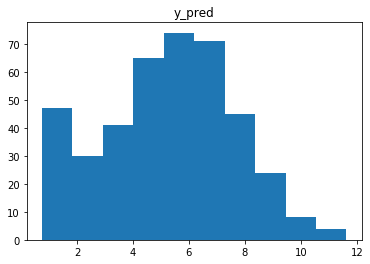

In [154]:
plt.hist(y_pred[:,0])
plt.title('y_pred')

Histogram 2

Text(0.5, 1.0, 'y_test')

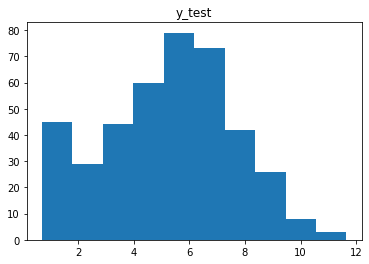

In [155]:
plt.hist(y_test[:,0])
plt.title('y_test')

Plot 1 - just a checkpoint for me to check if model is predicting reasonably well.  Pretty boring plot, but that is what we want.

Text(0.5, 1.0, 'Plot 1')

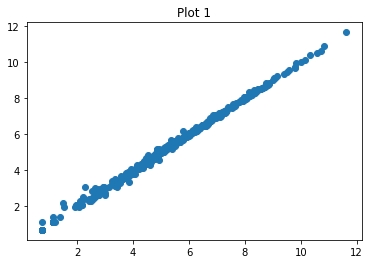

In [156]:
plt.scatter(y_pred[:, 0], y_test[:, 0])
plt.title('Plot 1')

Plot 2 

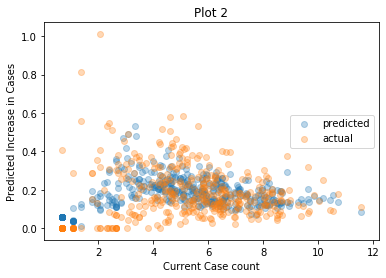

In [157]:
predicted_increase = y_pred - x_test[:, -1,:]
actual_increase = y_test - x_test[:, -1,:]
plt.scatter(x_test[:,-1,0], predicted_increase[:,0], alpha = 0.3, label = 'predicted')
plt.scatter(x_test[:,-1,0], actual_increase[:,0], alpha = 0.3, label = 'actual')
plt.title('Plot 2')
plt.xlabel('Current Case count')
plt.ylabel('Predicted Increase in Cases')
plt.legend(loc='right')
plt.show()

Plot 3

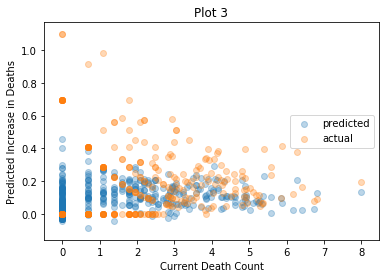

In [158]:
plt.scatter(x_test[:,-1,1], predicted_increase[:,1], alpha = 0.3, label='predicted')
plt.scatter(x_test[:,-1,1], actual_increase[:,1], alpha = 0.3, label='actual')
plt.title('Plot 3')
plt.xlabel('Current Death Count')
plt.ylabel('Predicted Increase in Deaths')
plt.legend(loc='right')
plt.show()

Plot 4

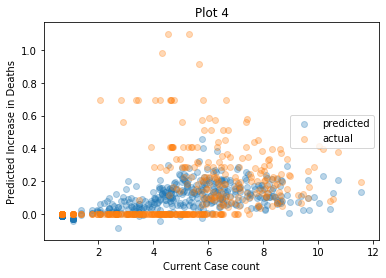

In [159]:
plt.scatter(x_test[:,-1,0], predicted_increase[:,1], alpha = 0.3, label='predicted')
plt.scatter(x_test[:,-1,0], actual_increase[:,1], alpha = 0.3, label='actual')
plt.title('Plot 4')
plt.xlabel('Current Case count')
plt.ylabel('Predicted Increase in Deaths')
plt.legend(loc='right')
plt.show()

Error Plot

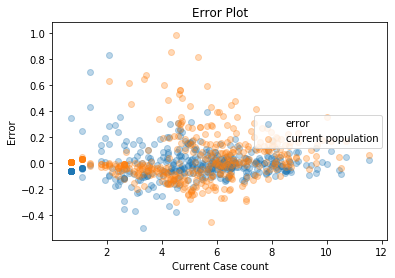

In [160]:
error = y_test - y_pred
plt.scatter(x_test[:,-1,0], error[:,0], alpha = 0.3, label='error')
plt.scatter(x_test[:,-1,0], error[:,1], alpha = 0.3, label='current population')
plt.title('Error Plot')
plt.xlabel('Current Case count')
plt.ylabel('Error')
plt.legend(loc='right')
plt.show()